In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from pandas.plotting import lag_plot

from sklearn.model_selection import train_test_split


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import itertools




In [3]:
air_df= pd.read_excel('Airlines+Data.xlsx')
air_df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [4]:
air_df.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


# Visualization of data for forecasting 

In [5]:
df_vis= pd.read_excel('Airlines+Data.xlsx', header=0, index_col=0, parse_dates=True, squeeze=True)
df_vis

Month
1995-01-01    112
1995-02-01    118
1995-03-01    132
1995-04-01    129
1995-05-01    121
             ... 
2002-08-01    405
2002-09-01    355
2002-10-01    306
2002-11-01    271
2002-12-01    306
Name: Passengers, Length: 96, dtype: int64

<AxesSubplot:xlabel='Month'>

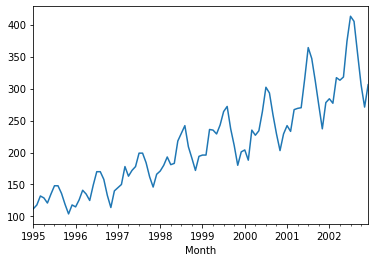

In [6]:
df_vis.plot()

<AxesSubplot:ylabel='Frequency'>

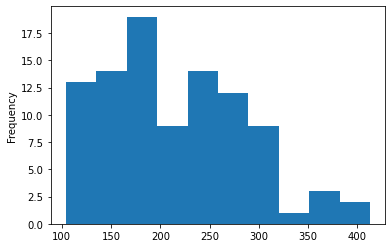

In [7]:
df_vis.plot(kind='hist')

<AxesSubplot:>

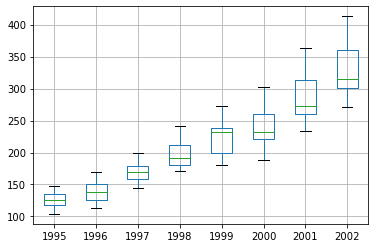

In [8]:
group= df_vis.groupby(pd.Grouper(freq='A'))
years= pd.DataFrame()

for i, j in group:
    years[i.year]=j.values
    
years.boxplot()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

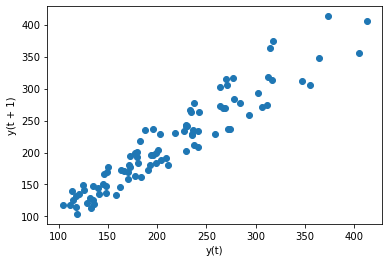

In [9]:
lag_plot(df_vis)

# Model building

In [10]:
train= air_df.head(75)
test= air_df.tail(21)

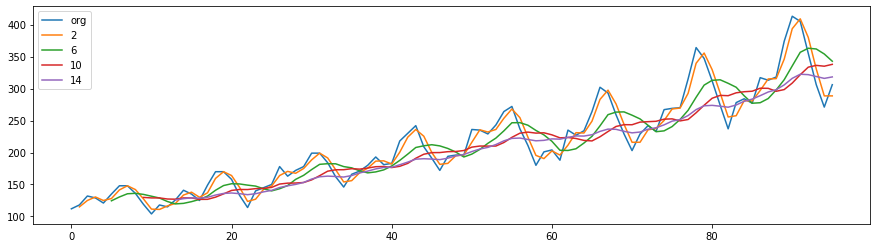

In [11]:
plt.figure(figsize=(15,4))
air_df.Passengers.plot(label='org')

for i in range(2,18,4):
    air_df.Passengers.rolling(i).mean().plot(label=str(i))
plt.legend()

# Evaluation metric MAPE

In [12]:
def Mape(pred, org):
    temp=np.abs((pred-org)/org)*100
    return np.mean(temp)

# Simple exponantial model 

In [13]:
train.Passengers= train.Passengers.astype('double')
sim_model= SimpleExpSmoothing(train['Passengers']).fit(smoothing_level=0.2)

In [14]:
sim_pred= sim_model.predict(start= test.index[0], end=test.index[-1])
sim_pred

75    243.498826
76    243.498826
77    243.498826
78    243.498826
79    243.498826
80    243.498826
81    243.498826
82    243.498826
83    243.498826
84    243.498826
85    243.498826
86    243.498826
87    243.498826
88    243.498826
89    243.498826
90    243.498826
91    243.498826
92    243.498826
93    243.498826
94    243.498826
95    243.498826
dtype: float64

In [15]:
sim_mape=Mape(sim_pred, test.Passengers)
sim_mape

21.264745162517233

# Holt model

In [16]:
holt_model= Holt(train.Passengers).fit(smoothing_level=0.8, smoothing_trend=0.2)

In [17]:
holt_pred=holt_model.predict(start=test.index[0], end= test.index[-1])
holt_pred

75    264.622591
76    269.082197
77    273.541803
78    278.001409
79    282.461015
80    286.920621
81    291.380227
82    295.839833
83    300.299439
84    304.759045
85    309.218651
86    313.678257
87    318.137864
88    322.597470
89    327.057076
90    331.516682
91    335.976288
92    340.435894
93    344.895500
94    349.355106
95    353.814712
dtype: float64

In [18]:
holt_mape=Mape(holt_pred, test.Passengers)
holt_mape

11.349331111998238

# Holt winter exponantial smoothing with additive seasonality  and additive trend

In [19]:
holtwin_model=ExponentialSmoothing(train.Passengers, seasonal='add', trend='add', seasonal_periods= 12).fit()

In [20]:
holtwin_pred= holtwin_model.predict(start=test.index[0], end= test.index[-1])
holtwin_pred

75    258.326870
76    257.327401
77    277.826911
78    298.826230
79    300.659332
80    277.158654
81    254.157802
82    233.157886
83    254.658227
84    258.738123
85    259.596017
86    286.881638
87    279.214409
88    278.214939
89    298.714450
90    319.713768
91    321.546870
92    298.046192
93    275.045340
94    254.045424
95    275.545765
dtype: float64

In [21]:
holtwin_model2_mape= Mape(holtwin_pred, test.Passengers)
holtwin_model2_mape

11.134437160138903

In [22]:
air_df['Passengers']=air_df['Passengers'].astype('double')
air_df

,Month,Passengers
0,1995-01-01,112.0
1,1995-02-01,118.0
2,1995-03-01,132.0
3,1995-04-01,129.0
4,1995-05-01,121.0
...,...,...
91,2002-08-01,405.0
92,2002-09-01,355.0
93,2002-10-01,306.0
94,2002-11-01,271.0


In [23]:
model= ExponentialSmoothing(air_df['Passengers'], seasonal= 'mul', trend='add', seasonal_periods=12).fit()

In [24]:
model.forecast(10)

96     312.899560
97     308.171547
98     355.533060
99     345.770145
100    345.696478
101    392.471215
102    436.501917
103    429.859801
104    380.173448
105    332.317859
dtype: float64